In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats

In [139]:
sns.set(style="darkgrid")

In [140]:
from sklearn.metrics import mean_squared_error as mse
def eval(target, predicted):
    return mse(np.log(target), np.log(predicted), squared=False)    

In [141]:
train = pd.read_csv("train.csv", index_col='Id')
test = pd.read_csv("test.csv", index_col='Id')

In [142]:
X = train.copy()
X_test = test.copy()

In [143]:
X.SalePrice.isna().any()  # there is no NaN in target.

False

In [144]:
X.shape, X_test.shape

((1460, 80), (1459, 79))

In [145]:
X.dtypes.unique(), X_test.dtypes.unique()

(array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object),
 array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object))

in which *dtype('O')* represents Nan values. 

## Handling Missing Data

Let's find the features containing missing values. Here's the list of them:

In [146]:
[(col, X[col].count()) for col in X 
                                 if X[col].count() < 1460]

[('LotFrontage', 1201),
 ('Alley', 91),
 ('MasVnrType', 1452),
 ('MasVnrArea', 1452),
 ('BsmtQual', 1423),
 ('BsmtCond', 1423),
 ('BsmtExposure', 1422),
 ('BsmtFinType1', 1423),
 ('BsmtFinType2', 1422),
 ('Electrical', 1459),
 ('FireplaceQu', 770),
 ('GarageType', 1379),
 ('GarageYrBlt', 1379),
 ('GarageFinish', 1379),
 ('GarageQual', 1379),
 ('GarageCond', 1379),
 ('PoolQC', 7),
 ('Fence', 281),
 ('MiscFeature', 54)]

We now separate categorical and numerical features with Nan values and study each:

In [147]:
nan_features_cat = [cols for cols in X if X[cols].isna().any()
               and X[cols].dtypes == 'object' ]
nan_features_num = [cols for cols in X if X[cols].isna().any()
               and X[cols].dtypes in ['int64', 'float64'] ]

nan_features_cat_test = [cols for cols in X_test if X_test[cols].isna().any()
               and X_test[cols].dtypes == 'object' ]
nan_features_num_test = [cols for cols in X_test if X_test[cols].isna().any()
               and X_test[cols].dtypes in ['int64', 'float64'] ]

In [148]:
X[nan_features_num].count()

LotFrontage    1201
MasVnrArea     1452
GarageYrBlt    1379
dtype: int64

We have three numeric features in the training data containing  NaN values, but some more in test data: 

In [149]:
X_test[nan_features_num_test].count()

LotFrontage     1232
MasVnrArea      1444
BsmtFinSF1      1458
BsmtFinSF2      1458
BsmtUnfSF       1458
TotalBsmtSF     1458
BsmtFullBath    1457
BsmtHalfBath    1457
GarageYrBlt     1381
GarageCars      1458
GarageArea      1458
dtype: int64

And, categorical features in the training and test data containing  NaN values are

In [150]:
X[nan_features_cat].count()

Alley             91
MasVnrType      1452
BsmtQual        1423
BsmtCond        1423
BsmtExposure    1422
BsmtFinType1    1423
BsmtFinType2    1422
Electrical      1459
FireplaceQu      770
GarageType      1379
GarageFinish    1379
GarageQual      1379
GarageCond      1379
PoolQC             7
Fence            281
MiscFeature       54
dtype: int64

In [151]:
X_test[nan_features_cat_test].count()

MSZoning        1455
Alley            107
Utilities       1457
Exterior1st     1458
Exterior2nd     1458
MasVnrType      1443
BsmtQual        1415
BsmtCond        1414
BsmtExposure    1415
BsmtFinType1    1417
BsmtFinType2    1417
KitchenQual     1458
Functional      1457
FireplaceQu      729
GarageType      1383
GarageFinish    1381
GarageQual      1381
GarageCond      1381
PoolQC             3
Fence            290
MiscFeature       51
SaleType        1458
dtype: int64

As it is seen, all categorical variables in training and test sets include NaN values. However, the NaN values might not necessarily represent missing values. For example: 

In [152]:
(train[train['GarageCond'].isna() & 
      train['GarageQual'].isna()]['GarageArea'] == 0).all()

True

which means 'GarageCond' and 'GarageQual' take NaN values *only* where there is not garage! these observations are not considered missing. So we correct this by substituting non-NaN values:

In [153]:
X.loc[pd.Index(X.GarageArea == 0),
      ['GarageType',
      'GarageFinish',
      'GarageQual',
      'GarageCond',]] = 'NoGarage'
X_test.loc[pd.Index(X_test.GarageArea == 0),
      ['GarageType',
      'GarageFinish',
      'GarageQual',
      'GarageCond',]] = 'NoGarage'

Similarly, we do the same for other features:

In [154]:
X.loc[pd.Index(X.PoolArea == 0),
      ['PoolQC']] = 'NoPool'
X_test.loc[pd.Index(X_test.PoolArea == 0),
      ['PoolQC']] = 'NoPool'

Similarly:

In [155]:
(train[train['BsmtQual'].isna()]['TotalBsmtSF'] == 0).all()

True

In [156]:
X.loc[pd.Index(X.TotalBsmtSF == 0),
                ['BsmtQual', 
                 'BsmtCond',
                 'BsmtFinType1',
                 'BsmtFinType2',
                 'BsmtExposure',
                ]] = 'NoBsmt'
X_test.loc[pd.Index(X_test.TotalBsmtSF == 0),
                ['BsmtQual', 
                 'BsmtCond',
                 'BsmtFinType1',
                 'BsmtFinType2',
                 'BsmtExposure',
                ]] = 'NoBsmt'

We now chech again for any possible missing value not captured so far. The following shows that there is missing values left for _BsmtExposure_ :

In [157]:
(train[train['BsmtExposure'].isna()]['TotalBsmtSF'] == 0).all()

False

and that is observation #949 only:

In [158]:
X[X['BsmtExposure'].isna()]['TotalBsmtSF']

Id
949    936
Name: TotalBsmtSF, dtype: int64

This is the only real missing record. We substitute it by 'No',
which is a typical value for 'No Exposure'.

In [159]:
X['BsmtExposure'].value_counts()

No        953
Av        221
Gd        134
Mn        114
NoBsmt     37
Name: BsmtExposure, dtype: int64

In [160]:
X.loc[949,'BsmtExposure'] = 'No' 

Three more missing values in test data:

In [161]:
X_test[X_test['BsmtExposure'].isna()][['BsmtExposure',
                                       'BsmtCond',
                                       'OverallQual']]

,BsmtExposure,BsmtCond,OverallQual
Id,,,
1488,NaN,TA,8
2121,NaN,NaN,4
2349,NaN,TA,5


We just plug in some values based on *OverallQual*. Had replaced them with the most freq values, we would have been fine:

In [162]:
X_test.loc[1488, 'BsmtExposure'] = 'Av'
X_test.loc[2121, 'BsmtExposure'] = 'Mn'
X_test.loc[2349, 'BsmtExposure'] = 'Mn'

Carrying on:

In [163]:
X[X['BsmtFinType2'].isna()][['BsmtFinSF2',
                             'BsmtUnfSF',
                             'BsmtFinSF1',
                             'TotalBsmtSF',
                             'BsmtFinType2',
                             'BsmtFinType1',
                             'BsmtQual']]

,BsmtFinSF2,BsmtUnfSF,BsmtFinSF1,TotalBsmtSF,BsmtFinType2,BsmtFinType1,BsmtQual
Id,,,,,,,
333,479,1603,1124,3206,NaN,GLQ,Gd


One single missing value only; sub in the most frequent value for the feature:

In [164]:
X['BsmtFinType2'].fillna('Rec', inplace=True) # Most freq value is 'Rec'

Next, check the test data:

In [165]:
X_test['BsmtFinType1'].count()

1458

In [166]:
X_test['BsmtFinType2'].count()

1458

There is one more missing value in _BsmtFinType1_ and _BsmtFinType2_ that should be filled:

In [167]:
# Replace by the most freq values
X_test['BsmtFinType1'].fillna('Unf', inplace=True)
X_test['BsmtFinType2'].fillna('Unf', inplace=True)

Similarly,

In [168]:
X_test['BsmtQual'].count()

1456

In [169]:
X_test[X_test['BsmtQual'].isna()][['BsmtQual',
                                  'BsmtCond',
                                  'OverallQual']]

,BsmtQual,BsmtCond,OverallQual
Id,,,
2121,NaN,NaN,4
2218,NaN,Fa,4
2219,NaN,TA,4


In [170]:
X_test.loc[2121, 'BsmtQual'] = 'TA'
X_test.loc[2218, 'BsmtQual'] = 'Fa'
X_test.loc[2219, 'BsmtQual'] = 'Fa'
X_test.loc[2121, ['BsmtQual', 'BsmtCond']] = 'Fa'

In [171]:
X_test[X_test['BsmtCond'].isna()][['BsmtQual',
                                  'BsmtCond',
                                  'OverallQual']]

,BsmtQual,BsmtCond,OverallQual
Id,,,
2041,Gd,NaN,8
2186,TA,NaN,6
2525,TA,NaN,5


In [172]:
X_test.loc[2041, 'BsmtCond'] = 'Gd'
X_test.loc[2186, 'BsmtCond'] = 'TA'
X_test.loc[2525, 'BsmtCond'] = 'TA'

We continue to other features:

In [173]:
X.loc[pd.Index(X.Fireplaces == 0),
      ['FireplaceQu']] = 'NoFirePlace'
X_test.loc[pd.Index(X_test.Fireplaces == 0),
      ['FireplaceQu']] = 'NoFirePlace'

In [174]:
X.loc[pd.Index(X.MasVnrArea == 0),
      ['MasVnrType']] = 'None'
X_test.loc[pd.Index(X_test.MasVnrArea == 0),
      ['MasVnrType']] = 'None'

Next is 'Electerical' feature with one single missing record replaced by the most freq value:

In [175]:
X['Electrical'].fillna('SBrkr', inplace=True)

According to data description, NaN value for feature "Fence" represents "No Fence": 

In [176]:
X['Fence'].fillna('No Fence', inplace=True)
X_test['Fence'].fillna('No Fence', inplace=True)

And, similarly

In [177]:
X['PoolQC'].fillna('No Pool', inplace=True)
X_test['PoolQC'].fillna('No Pool', inplace=True)

Now we check the counts again:

In [178]:
X[nan_features_cat].count()

Alley             91
MasVnrType      1452
BsmtQual        1460
BsmtCond        1460
BsmtExposure    1460
BsmtFinType1    1460
BsmtFinType2    1460
Electrical      1460
FireplaceQu     1460
GarageType      1460
GarageFinish    1460
GarageQual      1460
GarageCond      1460
PoolQC          1460
Fence           1460
MiscFeature       54
dtype: int64

Only three left:

In [179]:
X['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [180]:
X['MasVnrType'].value_counts()

None       866
BrkFace    444
Stone      127
BrkCmn      15
Name: MasVnrType, dtype: int64

In [181]:
X[(X['MasVnrType'].isna())][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN


In [182]:
X['MasVnrArea'].fillna(0, inplace=True) # Most freq value
X['MasVnrType'].fillna('None', inplace=True) # Most freq value

There are some more numerics features with missing values:

In [183]:
[((X[col].isna()).sum(), col) for col  in nan_features_num]

[(259, 'LotFrontage'), (0, 'MasVnrArea'), (81, 'GarageYrBlt')]

In the case of *GarageYrBlt* , the NaN values are due to non-existance of garage:

In [184]:
(X[X['GarageYrBlt'].isna()]['GarageArea'] == 0).all()

True

In [185]:
(train[train['GarageArea'] == 0]['GarageYrBlt']).all()

True

In this case, we choose to take 'YearBuilt' value as appropriate values for 'GarageYrBlt' because for most of the houses, these values are equal. In this case, 'GarageYrBlt' does not privide distinctive insight about the gragre. 

In [186]:
#X['GarageYrBlt'].fillna(X['GarageYrBlt'].mean(), inplace=True) # missing Garage Blt is set 1982. 

In [187]:
X.loc[pd.Index(X.GarageYrBlt.isna()),'GarageYrBlt'] = \
X.loc[pd.Index(X.GarageYrBlt.isna()),'YearBuilt']

This is not true for the test data:

In [188]:
(X_test[X_test['GarageYrBlt'].isna()]['GarageArea'] == 0).all()

False

In [189]:
(X_test[X_test['GarageYrBlt'].isna()]['GarageArea'] == 0).sum()

76

Out of the total:

In [190]:
X_test['GarageYrBlt'].isna().sum()

78

We take the risk for those 2 observations and move on to:

In [191]:
X_test.loc[pd.Index(X_test['GarageYrBlt'].isna()),
           'GarageYrBlt'] = \
X_test.loc[pd.Index(X_test['GarageYrBlt'].isna()),
       'YearBuilt']   

There is only one missing value for the following features:

In [192]:
X_test['GarageCars'].fillna(X['GarageCars'].mean(), inplace=True)
X_test['GarageArea'].fillna(X['GarageArea'].mean(), inplace=True)
X_test['BsmtFinSF1'].fillna(X['BsmtFinSF1'].mean(), inplace=True)
X_test['BsmtFinSF2'].fillna(X['BsmtFinSF2'].mean(), inplace=True)
X_test['BsmtUnfSF'].fillna(X['BsmtUnfSF'].mean(), inplace=True)
X_test['TotalBsmtSF'].fillna(X['TotalBsmtSF'].mean(), inplace=True)
X_test['BsmtFullBath'].fillna(X['BsmtFullBath'].mean(), inplace=True)
X_test['BsmtHalfBath'].fillna(X['BsmtHalfBath'].mean(), inplace=True)


The next feature is *LotFrontage* with 259 missing values of which  226 are Single Family Detched homes in the training data. About the same ratio holds for test data.

In [193]:
X[X['LotFrontage'].isna()]['BldgType'].value_counts()

1Fam      226
TwnhsE     22
Duplex      5
2fmCon      3
Twnhs       3
Name: BldgType, dtype: int64

In [194]:
X_test['LotFrontage'].isna().sum()

227

In [195]:
X_test[X_test['LotFrontage'].isna()]['BldgType'].value_counts()

1Fam      197
TwnhsE     16
Duplex     12
Twnhs       2
Name: BldgType, dtype: int64

In [196]:
m = X[X['BldgType'] == '1Fam']['LotFrontage'].mean() # 226 of missing values are Single Family Detched homes.
m

74.50301810865191

In [197]:
X['LotFrontage'].fillna(m, inplace=True) # missing 'LotFrontage' is set 75. 

In [198]:
X_test['LotFrontage'].fillna(m, inplace=True)

Diving deeper into the test data:

In [199]:
X_test['MasVnrArea'].isna().sum()

15

In [200]:
X_test.loc[pd.Index(X_test.MasVnrType.isna()),
                       'MasVnrType'] = 'None' # Most freq value
X_test.loc[pd.Index(X_test.MasVnrArea.isna()),
                       'MasVnrArea'] = 0

In [201]:
X_test.loc[pd.Index(X_test['Exterior1st'].isna()),
                           'Exterior1st'] = 'VinylSd' # Most freq value
X_test.loc[pd.Index(X_test['Exterior2nd'].isna()),
                           'Exterior2nd'] = 'VinylSd'

In [202]:
X_test['MSZoning'].fillna('RL', inplace=True) 

_KitchenQual_ has a single missing value in the test data:

In [203]:
X_test[X_test['KitchenQual'].isna()][['KitchenQual',
                                  'BsmtCond',
                                  'OverallQual']]

,KitchenQual,BsmtCond,OverallQual
Id,,,
1556,NaN,Fa,5


In [204]:
X_test.loc[1556, 'KitchenQual'] = 'Fa' # most freq value

Next feature is _Functional_ :

In [205]:
X_test[X_test['Functional'].isna()][['Functional',
                                  #'BsmtCond',
                                  'OverallQual']]

,Functional,OverallQual
Id,,
2217,NaN,1
2474,NaN,4


In [206]:
X_test['Functional'].fillna('Min1', inplace=True)

Now, Garage-related features:

In [207]:
X_test['GarageFinish'].isna().sum()

2

In [208]:
X_test['GarageFinish'].fillna('Unf', inplace=True)  # most freq value

In [209]:
X_test['GarageQual'].isna().sum()

2

In [210]:
X_test['GarageQual'].fillna('TA', inplace=True) # most freq value

In [211]:
X_test['GarageCond'].isna().sum()

2

In [212]:
X_test['GarageCond'].fillna('TA', inplace=True) # most freq value

And, finally *SaleType* : 

In [213]:
X_test['SaleType'].isna().sum()

1

In [214]:
X_test['SaleType'].fillna('WD', inplace=True)

Now, let's check to see what is left:

In [215]:
X_test[nan_features_cat_test].count()

MSZoning        1459
Alley            107
Utilities       1457
Exterior1st     1459
Exterior2nd     1459
MasVnrType      1459
BsmtQual        1459
BsmtCond        1459
BsmtExposure    1459
BsmtFinType1    1459
BsmtFinType2    1459
KitchenQual     1459
Functional      1459
FireplaceQu     1459
GarageType      1459
GarageFinish    1459
GarageQual      1459
GarageCond      1459
PoolQC          1459
Fence           1459
MiscFeature       51
SaleType        1459
dtype: int64

Some features have very low varience, which is not helpful when it comes to making predictions:

In [216]:
X_test['Utilities'].value_counts()

AllPub    1457
Name: Utilities, dtype: int64

We have chosen to drop some low-variance features:

In [217]:
X.drop(['Alley', 'Street', 'Utilities', 'MiscFeature',
           'PoolQC', 'CentralAir', 'PoolArea', 'LowQualFinSF',
       ], axis=1, inplace=True)
X_test.drop(['Alley', 'Street', 'Utilities', 'PoolQC',
             'MiscFeature', 'CentralAir', 'PoolArea', 
             'LowQualFinSF',], axis=1, inplace=True)

We have filled all missing data in both training and test data:

In [218]:
X.isna().any().any()

False

In [219]:
X_test.isna().any().any()

False

## Categorical encoding

To encode our categorical features, we will use a type of *target enconding*. Before implementing that, we put aside some features such as *Exterior1st* and *Exterior2nd*, which take the same set of values but but the values could be different for a given observation.

In [220]:
cat = X.columns[X.dtypes == 'object']
cat = list(cat)

cat.remove('Exterior1st')
cat.remove('Exterior2nd')

cat.remove('Condition1')
cat.remove('Condition2')

cat.remove('BsmtFinType1')
cat.remove('BsmtFinType2')


In [221]:
X[cat].isna().any().any(),  X_test[cat].isna().any().any()

(False, False)

The following function does the target encoding:

In [222]:
def ordinal_map(col):
    c = X.groupby(col)[['SalePrice']].\
    apply(lambda x:  x.median()).\
    sort_values(by='SalePrice').reset_index().drop(columns=['SalePrice'])
    d = {str(v):i for i,v in zip(np.arange(1, len(c) + 1),c.values.ravel())}
    return d



Apply the function to the categorical features below:

In [223]:
for col in cat:
    gategories = ordinal_map(col)
    X.loc[:, col] = X[[col]].applymap(gategories.get)
    X_test.loc[:, col] = X_test[[col]].applymap(gategories.get)


We now treat the special features with same value separately to ensure a unified encoding:

In [224]:
gategories = ordinal_map('Condition1')
X.loc[:, 'Condition1'] = X[['Condition1']].applymap(gategories.get)
X_test.loc[:, 'Condition1'] = X_test[['Condition1']].applymap(gategories.get)
X.loc[:, 'Condition2'] = X[['Condition2']].applymap(gategories.get)
X_test.loc[:, 'Condition2'] = X_test[['Condition2']].applymap(gategories.get)

In [225]:
gategories = ordinal_map('BsmtFinType1')
X.loc[:, 'BsmtFinType1'] = X[['BsmtFinType1']].applymap(gategories.get)
X_test.loc[:, 'BsmtFinType1'] = X_test[['BsmtFinType1']].applymap(gategories.get)
X.loc[:, 'BsmtFinType2'] = X[['BsmtFinType2']].applymap(gategories.get)
X_test.loc[:, 'BsmtFinType2'] = X_test[['BsmtFinType2']].applymap(gategories.get)

We noticed some descrepancies in spelling values for features *Exterior1st* and *Exterior2nd*. Here we try to fix this first before we apply the encoding:

In [226]:
X.loc[pd.Index(X['Exterior2nd'] == 'Wd Shng'),'Exterior2nd'] = 'WdShing'
X_test.loc[pd.Index(X_test['Exterior2nd'] == 'Wd Shng'),'Exterior2nd'] = 'WdShing'

X.loc[pd.Index(X['Exterior2nd'] == 'Brk Cmn'),'Exterior2nd'] = 'BrkComm'
X_test.loc[pd.Index(X_test['Exterior2nd'] == 'Brk Cmn'),'Exterior2nd'] = 'BrkComm'

X.loc[pd.Index(X['Exterior2nd'] == 'CmentBd'), 'Exterior2nd'] = 'CemntBd'
X_test.loc[pd.Index(X_test['Exterior2nd'] == 'CmentBd'), 'Exterior2nd'] = 'CemntBd'


In [227]:
gategories = ordinal_map('Exterior1st')
X.loc[:, 'Exterior1st'] = X[['Exterior1st']].applymap(gategories.get)
X_test.loc[:, 'Exterior1st'] = X_test[['Exterior1st']].applymap(gategories.get)
X.loc[:, 'Exterior2nd'] = X[['Exterior2nd']].applymap(gategories.get)
X_test.loc[:, 'Exterior2nd'] = X_test[['Exterior2nd']].applymap(gategories.get)


There is one single value "Other" for feature 'Exterior2nd' that is not taken by 'Exterior1st' so it doesnt transfer from 'Exterior1st' to 'Exterior2nd' by our encoding transformer. We encode it manually to a new value.

In [228]:
X.loc[596, 'Exterior2nd'] = 16 # This was equal to 'Other'.

Now let's look at the correlation matrix:

In [229]:
corr = X.corr()
corr.shape

(72, 72)

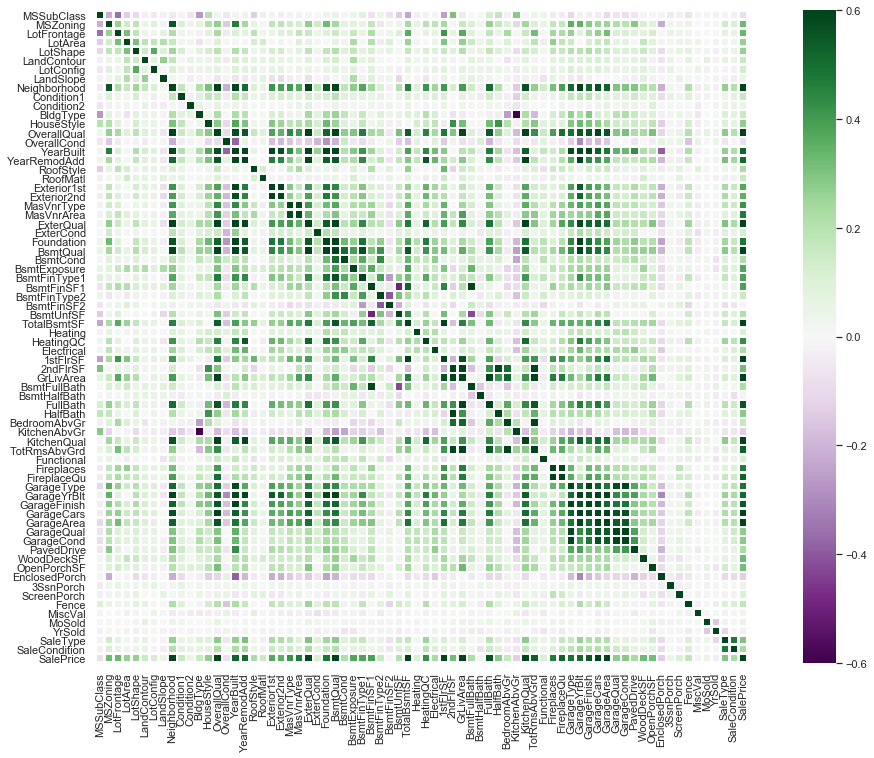

In [230]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap='PRGn', vmax=.6,
            vmin=-.6,
            center=0,
            square=True, 
            linewidths=1.5,
            yticklabels=True,
            cbar_kws={"shrink": 1})

plt.show()

In [231]:
sorted([(col, X[col].corr(X['SalePrice'])) for col in X],
         key=lambda x:x[1], reverse=True)

[('SalePrice', 0.9999999999999998),
 ('OverallQual', 0.7909816005838043),
 ('GrLivArea', 0.7086244776126521),
 ('Neighborhood', 0.6961576812894039),
 ('ExterQual', 0.6826392416562593),
 ('KitchenQual', 0.6595997207286638),
 ('GarageCars', 0.6404091972583528),
 ('GarageArea', 0.6234314389183617),
 ('BsmtQual', 0.6229247260588419),
 ('TotalBsmtSF', 0.6135805515591953),
 ('1stFlrSF', 0.6058521846919146),
 ('FullBath', 0.5606637627484449),
 ('GarageFinish', 0.5492467563332116),
 ('TotRmsAbvGrd', 0.533723155582028),
 ('FireplaceQu', 0.5259323551065522),
 ('YearBuilt', 0.5228973328794968),
 ('GarageYrBlt', 0.5080432871615159),
 ('YearRemodAdd', 0.5071009671113864),
 ('GarageType', 0.48952805645834885),
 ('Foundation', 0.4784307475525258),
 ('MasVnrArea', 0.4726144990045745),
 ('Fireplaces', 0.46692883675152697),
 ('HeatingQC', 0.42764870739880395),
 ('MasVnrType', 0.4199327140801447),
 ('BsmtFinSF1', 0.38641980624215305),
 ('BsmtFinType1', 0.3812132277627985),
 ('BsmtExposure', 0.37504495892

## Features Engineering and Analysis 

In this section, I study the interaction between different features and the target variable. I will employ various ways of extracting and creating new features that are potentially helpful
for different model, specially tree-based models. 

0.3555721121600623
0.3710183981593035


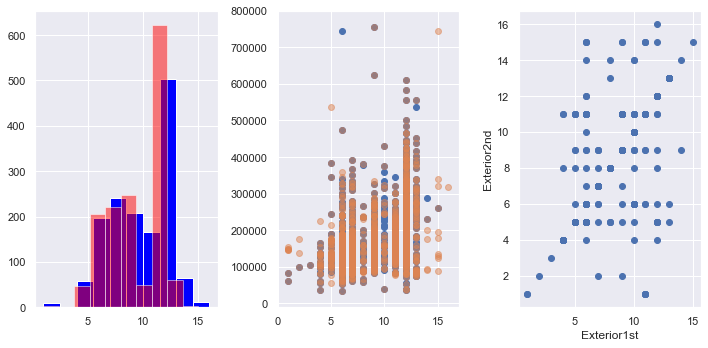

In [232]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(131)
ax1.hist(X['Exterior2nd'], color='blue')
ax1.hist(X['Exterior1st'], color = 'red', alpha=0.5)
print((X['Exterior2nd']).corr(X['SalePrice']))
print((X['Exterior1st']).corr(X['SalePrice']))



ax2 = fig.add_subplot(132)
ax2.scatter(X['Exterior1st'], X['SalePrice'])
ax2.scatter((X['Exterior2nd']), X['SalePrice'], alpha=0.5)

ax3 = fig.add_subplot(133)
ax3.scatter(X['Exterior1st'], X['Exterior2nd'])
plt.xlabel('Exterior1st')
plt.ylabel('Exterior2nd')


plt.tight_layout()
plt.show()

#(train['GarageArea']+ train['TotalBsmtSF']).corr(X['SalePrice'])

For how many records are 'Exterior1st' and 'Exterior2nd' equal?

In [233]:
(X['Exterior2nd'] == X['Exterior1st']).sum()/1460

0.9061643835616439

Over 90% of times. 

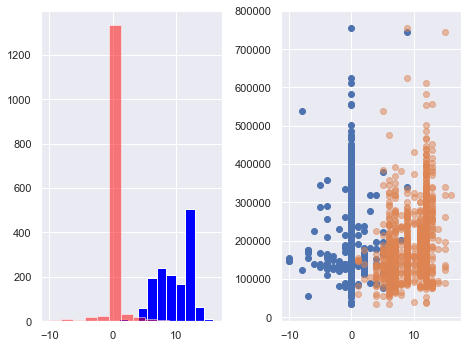

In [234]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(131)
ax1.hist(X['Exterior2nd'], color='blue')
ax1.hist(X['Exterior2nd'] - X['Exterior1st'], color = 'red', alpha=0.5)



ax2 = fig.add_subplot(132)
ax2.scatter(X['Exterior2nd'] - X['Exterior1st'], X['SalePrice'])
ax2.scatter((X['Exterior2nd']), X['SalePrice'], alpha=0.5)


plt.tight_layout()
plt.show()

The difference of two features provide smaller entropy so we substitue it for one of the features:

In [235]:
X['Exterior2nd'] = X['Exterior2nd'] - X['Exterior1st']
X_test['Exterior2nd'] = X_test['Exterior2nd'] - X_test['Exterior1st']

Similarly

In [236]:
X['Condition2'] = X['Condition2'] - X['Condition1']
X_test['Condition2'] = X_test['Condition2'] - X_test['Condition1']

### Numerical feature analysis

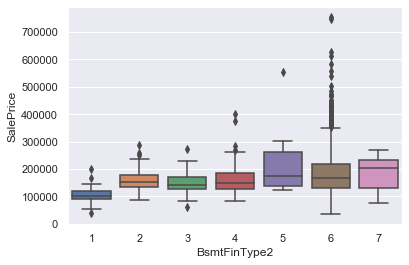

In [237]:
sns.boxplot(X['BsmtFinType2'], X['SalePrice'])

'BsmtUnfSF' is dependent on 'BsmtFinSF1', 'BsmtFinSF1', 'TotalBsmtSF'. So we drop it.

In [238]:
X.drop('BsmtUnfSF', axis=1, inplace=True)
X_test.drop('BsmtUnfSF', axis=1, inplace=True)

0.38641980624215305
0.47151677559528204


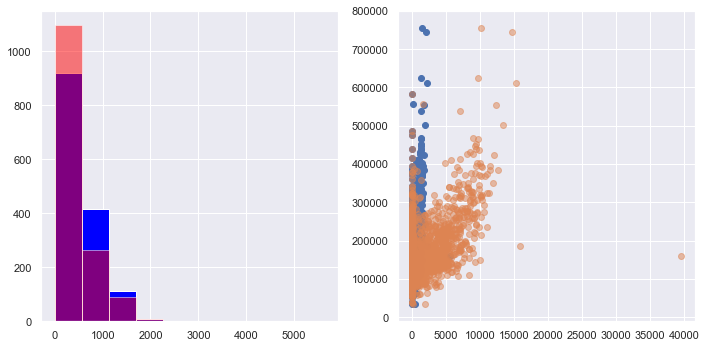

In [239]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.hist(X['BsmtFinSF1'], color='blue')
ax1.hist(X['BsmtFinSF1']*X['BsmtFinType1']/7, color = 'red', alpha=0.5)
print((X['BsmtFinSF1']).corr(X['SalePrice']))
print((X['BsmtFinSF1']*X['BsmtFinType1']).corr(X['SalePrice']))



ax2 = fig.add_subplot(122)
ax2.scatter(X['BsmtFinSF1'], X['SalePrice'])
ax2.scatter(X['BsmtFinSF1']*X['BsmtFinType1'], X['SalePrice'], alpha=0.5)


plt.tight_layout()
plt.show()

This change have slightly improved both entropy and correlation.

In [240]:
X.loc[:,'BsmtFinSF1'] = X['BsmtFinSF1']*X['BsmtFinType1']
X.loc[:,'BsmtFinSF2'] = X['BsmtFinSF2']*X['BsmtFinType2']

In [241]:
X_test.loc[:,'BsmtFinSF1'] = X_test['BsmtFinSF1']*X_test['BsmtFinType1']
X_test.loc[:,'BsmtFinSF2'] = X_test['BsmtFinSF2']*X_test['BsmtFinType2']

Now we look at a new feature made from area related features and compare it to the strongest area-base feature, which is *GrLivArea* :

In [242]:
new_feature = X['TotalBsmtSF']+X['1stFlrSF']+X['2ndFlrSF']

0.7086244776126521
0.782260052797984


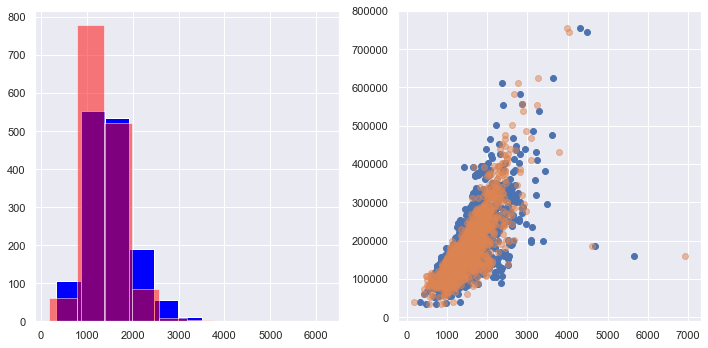

In [243]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.hist(X['GrLivArea'], color='blue')
ax1.hist(new_feature/1.9, color = 'red', alpha=0.5)
print((X['GrLivArea']).corr(X['SalePrice']))
print((new_feature/1.7).corr(X['SalePrice']))



ax2 = fig.add_subplot(122)
ax2.scatter(X['GrLivArea'], X['SalePrice'])
ax2.scatter((new_feature)/1.7, X['SalePrice'], alpha=0.5)


plt.tight_layout()
plt.show()



62.0

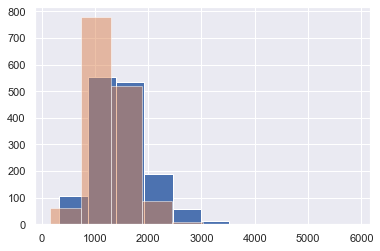

In [244]:
plt.hist(X['GrLivArea'])[0]
plt.hist(new_feature/2,alpha=0.5)[0][0]

The new feature is called 'LivArea'.

In [245]:
X['LivArea'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X_test['LivArea'] = X_test['TotalBsmtSF'] + X_test['1stFlrSF'] + X_test['2ndFlrSF']

A parametric t-test confirms that the new feature has statistically mean. 

In [246]:
stats.ttest_ind(X['GrLivArea'], X['LivArea'])

Ttest_indResult(statistic=-41.195705016299954, pvalue=8.080463543129553e-293)

A non-parametric test confirms the same as well.

In [247]:
stats.wilcoxon(X['GrLivArea'], X['LivArea'])

WilcoxonResult(statistic=1.0, pvalue=2.46559641348542e-234)

Also we try to improve the entropy in the following:

In [248]:
(X['GrLivArea'] >= X['1stFlrSF']).all()

True

In [249]:
(train['1stFlrSF'] >= train['2ndFlrSF']).sum()

1325

In [250]:
X.loc[:, '2ndFlrSF'] = X['1stFlrSF'] - X['2ndFlrSF']
X_test.loc[:, '2ndFlrSF'] = X_test['1stFlrSF'] - X_test['2ndFlrSF']

In [251]:
X.loc[:, '1stFlrSF'] = X['GrLivArea'] - X['1stFlrSF']
X_test.loc[:, '1stFlrSF'] = X_test['GrLivArea'] - X_test['1stFlrSF']

Now feature '2ndFlrSF' provides very low correlation with SalePrice. So we drop it!

In [252]:
X.drop('2ndFlrSF', axis=1, inplace=True)
X_test.drop('2ndFlrSF', axis=1, inplace=True)

The following new feature could help understand the shape of the land in most cases:

In [253]:
X['LotLength'] = X['LotArea'] / X['LotFrontage']
X_test['LotLength'] = X_test['LotArea'] / X_test['LotFrontage']

Next we compare three types differences for year-base features:

In [254]:
(X['YearRemodAdd'] - X['YearBuilt']).corr(X['SalePrice'])

-0.2175033152200017

In [255]:
(X['YearRemodAdd'] - X['YrSold']).corr(X['SalePrice'])

0.5090787380156293

In [256]:
(X['YearBuilt'] - X['YrSold']).corr(X['SalePrice'])

0.5233504175468158

array([1049.,   72.,  117.,   67.,   49.,   34.,   38.,   21.,    8.,
          5.])

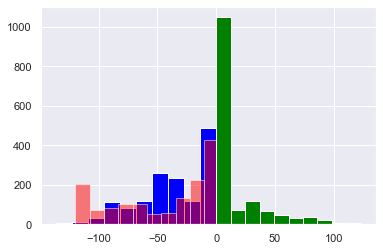

In [257]:
plt.hist(X['YearBuilt'] - X['YrSold'], color='blue')[0]
plt.hist((X['YearRemodAdd'] - X['YrSold'])*2, color='red', alpha=0.5)[0]
plt.hist(X['YearRemodAdd'] - X['YearBuilt'], color='green')[0]

The difference between 'YearBuilt' and 'YrSold' provides a btter baclance for correlation and a lower variance distribution.

In [258]:
X['Age'] = X['YrSold'] - X['YearBuilt']
X_test['Age'] = X_test['YrSold'] - X_test['YearBuilt']

The difference between 'YearRemodAdd' and 'YrSold' shows very strong correlation and similar disribution to 'YearRemodAdd'. Thus it probably will not imporve our model much in presence of 'YearRemodAdd'. 

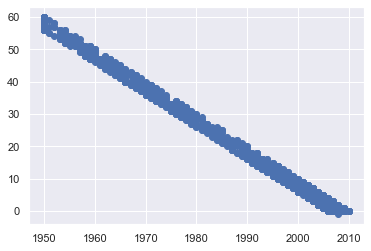

In [259]:
plt.scatter(X['YearRemodAdd'], X['YrSold'] - X['YearRemodAdd'])

For the same reason as mentioned before, we add the following new feature:

0.5936975843533545
0.533723155582028


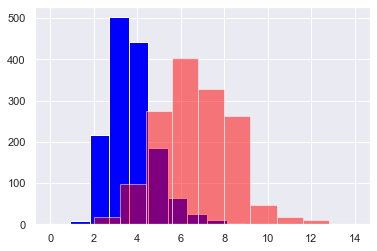

In [260]:
plt.hist(X['TotRmsAbvGrd'] - X['BedroomAbvGr'], color='blue')[0]
plt.hist(X['TotRmsAbvGrd'], color='red', alpha=0.5)[0]

print((X['TotRmsAbvGrd'] - X['BedroomAbvGr']).corr(X['SalePrice']))
print((X['TotRmsAbvGrd']).corr(X['SalePrice']))

In [261]:
X['RmsAbvGr'] = X['TotRmsAbvGrd'] - X['BedroomAbvGr']
X_test['RmsAbvGr'] = X_test['TotRmsAbvGrd'] - X_test['BedroomAbvGr']

and drop one of the componenets:

In [262]:
X.drop('TotRmsAbvGrd', axis=1, inplace=True)
X_test.drop('TotRmsAbvGrd', axis=1, inplace=True)

In fact, 'TotRmsAbvGrd' was relaced by the new feature.

Another new feature is related to area:

In [263]:
X['Area'] = X['GrLivArea'] + X['GarageArea']
X_test['Area'] = X_test['GrLivArea'] + X_test['GarageArea']

In [264]:
X['Area'].corr(X['SalePrice']), X['Area'].corr(X['GrLivArea'])

(0.7736250045628492, 0.9573592962378956)

In [265]:
stats.ttest_ind(X['GrLivArea'], X['Area'])

Ttest_indResult(statistic=-21.549232712085576, pvalue=1.0605855414237365e-95)

array([ 62., 778., 521.,  86.,   8.,   3.,   1.,   0.,   0.,   1.])

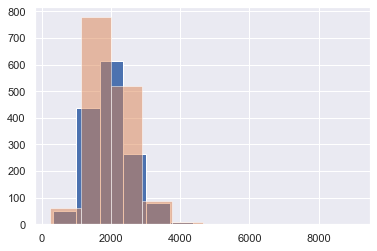

In [266]:
plt.hist((X['Area']))[0]
plt.hist((X['LivArea'])/1.3, alpha=0.5)[0]

In [267]:
corr = X.corr()
corr.shape

(74, 74)

In [268]:
sorted([(col, X[col].corr(X['SalePrice'])) for col in X.columns],
         key=lambda x:x[1], reverse=True)


[('SalePrice', 0.9999999999999998),
 ('OverallQual', 0.7909816005838043),
 ('LivArea', 0.7822600527979845),
 ('Area', 0.7736250045628492),
 ('GrLivArea', 0.7086244776126521),
 ('Neighborhood', 0.6961576812894039),
 ('ExterQual', 0.6826392416562593),
 ('KitchenQual', 0.6595997207286638),
 ('GarageCars', 0.6404091972583528),
 ('GarageArea', 0.6234314389183617),
 ('BsmtQual', 0.6229247260588419),
 ('TotalBsmtSF', 0.6135805515591953),
 ('RmsAbvGr', 0.5936975843533545),
 ('FullBath', 0.5606637627484449),
 ('GarageFinish', 0.5492467563332116),
 ('FireplaceQu', 0.5259323551065522),
 ('YearBuilt', 0.5228973328794968),
 ('GarageYrBlt', 0.5080432871615159),
 ('YearRemodAdd', 0.5071009671113864),
 ('GarageType', 0.48952805645834885),
 ('Foundation', 0.4784307475525258),
 ('MasVnrArea', 0.4726144990045745),
 ('BsmtFinSF1', 0.47151677559528204),
 ('Fireplaces', 0.46692883675152697),
 ('HeatingQC', 0.42764870739880395),
 ('MasVnrType', 0.4199327140801447),
 ('BsmtFinType1', 0.3812132277627985),
 ('B

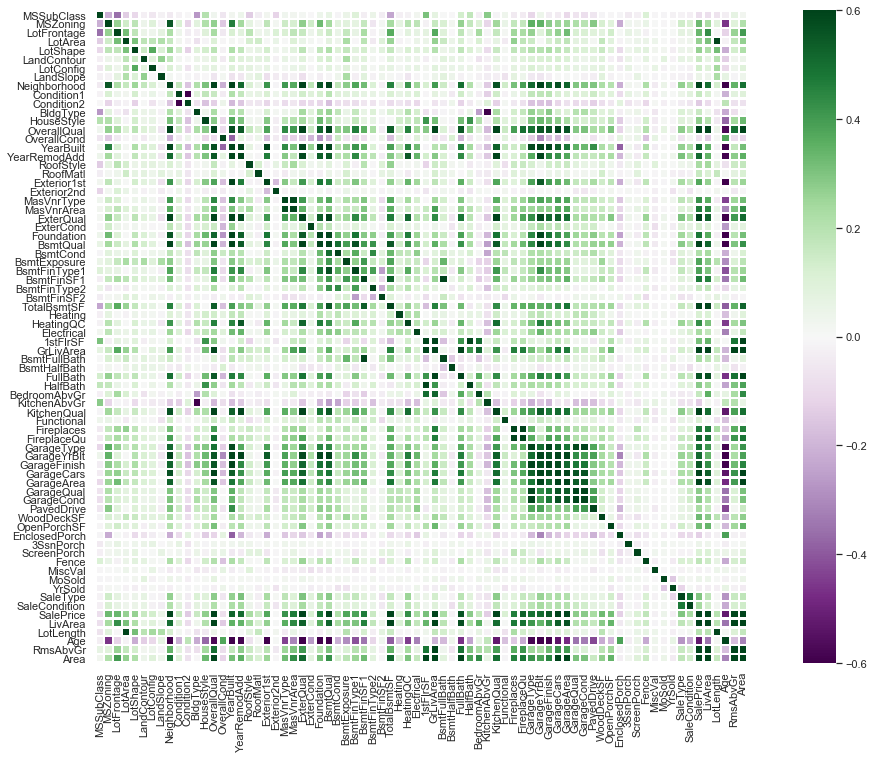

In [269]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap="PRGn", vmax=.6,
            vmin=-.6,
            center=0,
            square=True, 
            linewidths=1.5,
            yticklabels=True,
            #annot=True,
            cbar_kws={"shrink": 1})

plt.show()

### Prepare data for feeding the model:

In [270]:
X_train_f = X.drop(['SalePrice'], axis=1)
y_train_f = X.SalePrice

In [271]:
X_train_f.shape

(1460, 73)

Now that our data is prepared, we can start training model. Our first model is a LGBM model:

In [272]:
import lightgbm as lgb

model = lgb.LGBMRegressor(n_estimators=1000,
                         max_depth=-1,
                         num_leaves=35,
                         learning_rate=0.03,
                         min_data_in_leaf= 1,
                         reg_alpha = 0.01,
                         min_child_weight= 0.9,
                         random_state=0,
                         subsample= 0.6,
                         n_jobs=-1,
                         colsample_bytree=0.3,
                         subsample_freq=3
                         )

In [283]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer, mean_absolute_error
score = make_scorer(eval, greater_is_better=False)


train_scores, valid_scores = validation_curve(model,
                                          X_train_f, 
                                          y_train_f,
                                          'n_estimators',
                                          [1000],
                                          scoring=score,
                                          cv=i+3,
                                          n_jobs=-1)
print('Train Error: ', train_scores.mean())
print('Valid Error: ', valid_scores.mean())

Train Error:  -0.0037062529415669543
Valid Error:  -0.11879898771461912


In [274]:
score = make_scorer(mean_absolute_error, greater_is_better=False)

train_scores, valid_scores = validation_curve(model,
                                              X_train_f, 
                                              y_train_f,
                                              'loss',
                                              ['ls'],
                                              scoring=score,
                                              cv=5,
                                              n_jobs=-1)
print('The train score is:\n', train_scores.mean())
print('The valid score is:\n', valid_scores.mean())

The train score is:
 -414.3992691536332
The valid score is:
 -14031.314029817597


In [143]:
model.fit(X_train_f, y_train_f)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.9, min_data_in_leaf=1,
              min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=35,
              objective=None, random_state=0, reg_alpha=0.01, reg_lambda=0.0,
              silent=True, subsample=0.6, subsample_for_bin=200000,
              subsample_freq=3)

We can generate *permutation importance* for features from SKLearn:  

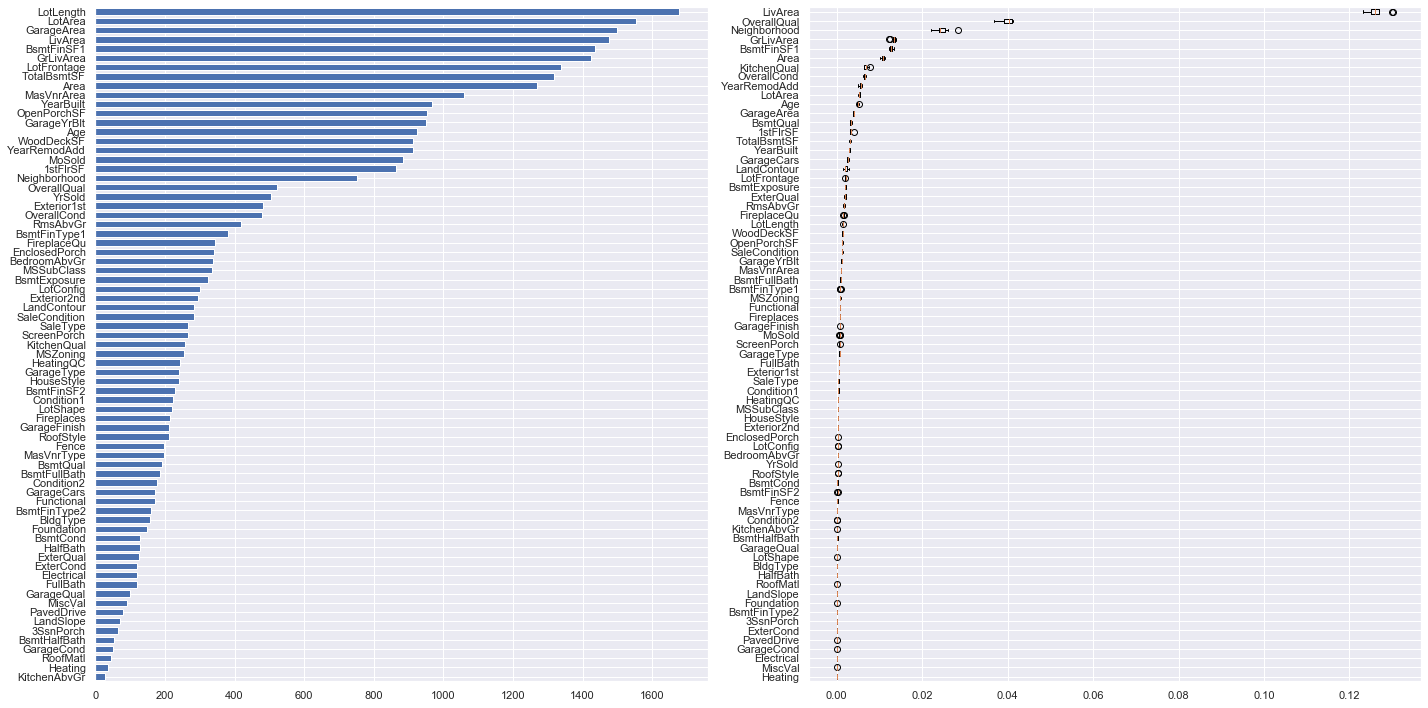

In [144]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_train_f, y_train_f, 
                                n_repeats=10, 
                                random_state=42, n_jobs=-1)
perm_importance_sorted_idx = np.argsort(result.importances_mean)

tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_indices = np.arange(0, 
                         len(model.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.barh(tree_indices,
         model.feature_importances_[tree_importance_sorted_idx], 
         height=0.7)
ax1.set_yticklabels(X_train_f.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model.feature_importances_)))
#ax1.set_xlim((0, 0.2))
ax2.boxplot(result.importances[perm_importance_sorted_idx].T, 
            vert=False,
            labels=X_train_f.columns[perm_importance_sorted_idx])
fig.tight_layout()
plt.show()

Now let us train a XGBoost Model. We set the parameters as follow:

In [279]:
params = {'eval_metric': ['rmsle', 'mae'],
          'learning_rate': 0.03,
          'max_depth': 5,
          'n_jobs': -1, 
          'alpha': 1,
          'verbosity': 0,
          'min_child_weight': 1,
          'subsample': 0.6,
          'colsample_bytree': 0.3,
          'colsample_bylevel': 1,
          'tree_method': 'hist',
          'seed': 0,
          'disable_default_eval_metric': 1,
          'num_parallel_tree': 20,
             }

Covert the data into XGBoost data structure: 

In [280]:
dtrain = xgb.DMatrix(data=X_train_f, label=y_train_f)

Let'see how the model is doing:

In [143]:
xgb.cv(params, 
       dtrain,
       num_boost_round=1000,
       nfold=5,
       stratified=False,
       seed=0,
       shuffle=True,
       ).drop(['train-rmsle-std',
                'train-mae-std',
                'test-rmsle-std',
                'test-mae-std',
               ], axis=1).tail(1)

,train-rmsle-mean,train-mae-mean,test-rmsle-mean,test-mae-mean
999,0.020549,2203.335693,0.117663,13811.641406


Which is a slightly better performace compared to our Lightlgm model. We now train our model using the entire data with the parameters above:

In [281]:
bst = xgb.train(params, 
                    dtrain,
                    1000,
                    maximize=False,
                    verbose_eval =False,
                )

And finally, we make predictions on our test data:

In [148]:
bst.predict(xgb.DMatrix(X_test)) # The Best Prediction

array([128522.484, 160009.53 , 189047.95 , ..., 170637.16 , 123548.555,
       210632.84 ], dtype=float32)

If we want to submit the predictions for evaluations by Kaggle.com, we save them in a *csv* format file:

In [149]:
prediction = bst.predict(xgb.DMatrix(X_test))
Submit = pd.DataFrame({'SalePrice': prediction}, index=X_test.index)
Submit.to_csv("Submit.csv")

Here is feature impartance in view of our model:

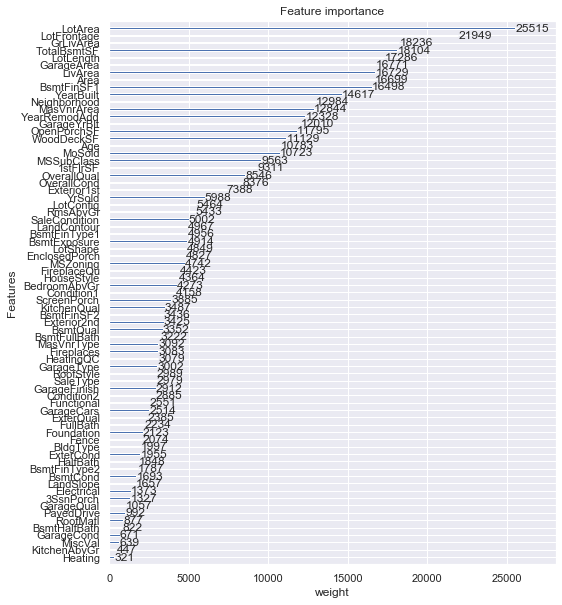

In [284]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot()
xgboost.plot_importance(bst, 
                        ax=ax, 
                        height=0.2, 
                        xlim=None, 
                        ylim=None, 
                        title='Feature importance', 
                        xlabel='weight', 
                        ylabel='Features', 
                        importance_type='weight', 
                        max_num_features=None, 
                        grid=True, 
                        show_values=True, 
                        )

plt.show()